In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow.python.ops import array_ops
import numpy as np
import matplotlib.pyplot as plt
import processes
from processes import orstein_uhlenbeck as ou
import utils
from utils import kalman
import buildingblocks
from buildingblocks import stupidcell

/Users/apple/anaconda3/envs/DeepLearning/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/apple/anaconda3/envs/DeepLearning/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Network

In [2]:
def build_optimizer(loss, learning_rate, grad_clip):
    ''' Build optmizer for training, using gradient clipping.
    
        Arguments:
        loss: Network loss
        learning_rate: Learning rate for optimizer
    
    '''
    
    # Optimizer for training, using gradient clipping to control exploding gradients
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), grad_clip)
    train_op = tf.train.AdamOptimizer(learning_rate)
    optimizer = train_op.apply_gradients(zip(grads, tvars))
    
    return optimizer

In [3]:

graph=tf.Graph()


In [4]:
logs_dir = './graphs/'
batch_size=128
num_steps=1095
lstm_layers= 1
lstm_size= 10
inputs_dim= 1
alpha = 0.1

In [5]:
with graph.as_default():
    inputs_ = tf.placeholder( tf.float32, [batch_size,num_steps, inputs_dim] , name='inputs')
    targets_ = tf.placeholder( tf.float32, [batch_size,num_steps, inputs_dim] , name='targets')
    learning_rate= tf.placeholder( tf.float32 , name='lr')
    grad_clip= tf.placeholder( tf.float32 , name='clip')

In [6]:

with graph.as_default():
    cell = stupidcell.StupidRNNCell(1,activation= None)
    lstm = tf.nn.rnn_cell.BasicLSTMCell(lstm_size)
    lstm = tf.contrib.rnn.ResidualWrapper( lstm, (lambda i, o: array_ops.concat([i,o],1)) )
    
    rnn_cell = tf.contrib.rnn.MultiRNNCell([lstm,cell])
# 'outputs' is a tensor of shape [batch_size, max_time, cell_state_size]

# defining initial state
    initial_state = rnn_cell.zero_state(batch_size, dtype=tf.float32)

# 'state' is a tensor of shape [batch_size, cell_state_size]
    outputs, state = tf.nn.dynamic_rnn(rnn_cell, inputs_,
                                   initial_state=initial_state,
                                   dtype=tf.float32)
    '''
    W = tf.Variable(tf.random_normal([lstm_size, inputs_dim]), dtype=tf.float32) # weights
    b = tf.Variable(tf.random_normal([ inputs_dim]), dtype=tf.float32) # biases
    shape = outputs.shape
    
    outputs = tf.matmul( tf.reshape( outputs, [-1, lstm_size]), W ) + b
    outputs = tf.reshape( outputs, (shape[0],shape[1],b.shape[0]))
    '''


(128, 2)


In [7]:
with graph.as_default():
    square=  tf.reduce_mean( tf.square( outputs - targets_),axis=0 )
    shape = square.shape
    square = tf.reshape(square, [shape[0],])
    def power(x):
        alpha =0.97
        return (1-alpha)*tf.pow(alpha,x)
    weights = tf.map_fn(  power, tf.range( start= shape[0]-1, delta=-1., limit= -0.5  ) )
    cost = tf.losses.compute_weighted_loss( square, weights )
    optimizer= build_optimizer(cost, learning_rate, grad_clip)
    

## Batch

In [8]:


def batch_1( batch_size, num_steps, noise, dictionary,):
    while True:
        invariant_std = 0.3 +0.6*np.random.rand()
        lbd = 10**( 2*np.random.rand() -1 )
        sigma = invariant_std*np.sqrt(2*lbd)
        dictionary['sigma'] = sigma
        dictionary['lbd'] = lbd

        batch = np.random.randn( batch_size,num_steps+1,1)*noise
        trend =np.reshape( ou.process(**dictionary)[: num_steps+1] , [-1,1] )
        for i in range(batch_size):
            batch[i,:,:]=batch[i,:,:]+trend[:,:]
        
        yield (batch[:,:-1,:] , batch[:,1:,:],trend, dictionary )

    

In [9]:
invariant_std = 0.2
lbd = 1.
sigma = invariant_std*np.sqrt(2*lbd)
start= 365
dictionary = {'deltaT': 1./365,
              'T':3}
noise= 0.1/np.sqrt( dictionary['deltaT'])
generator1 = batch_1( batch_size , num_steps,noise ,dictionary)

In [ ]:
generator= generator1

## Training

## Batch 1

-3.646035641524942


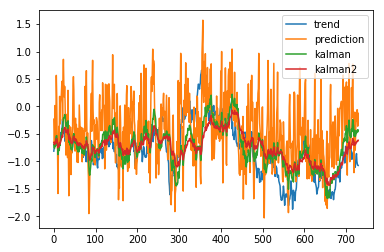

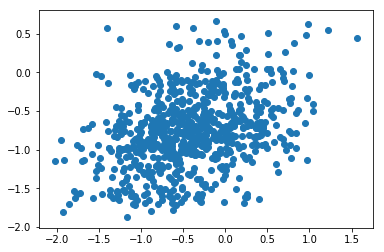

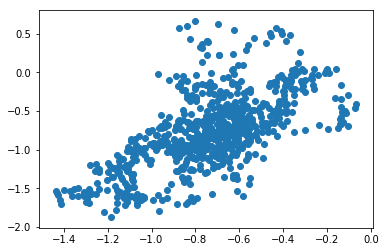

-3.6464406632352633


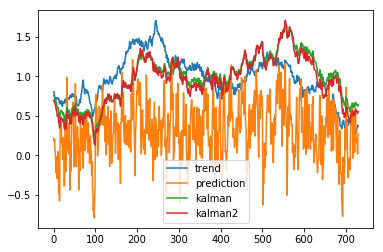

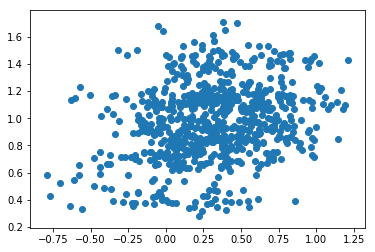

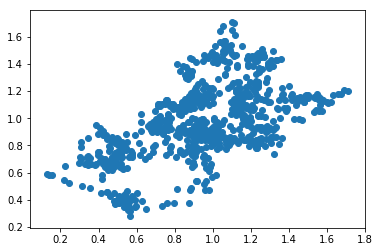

-3.646530403615908


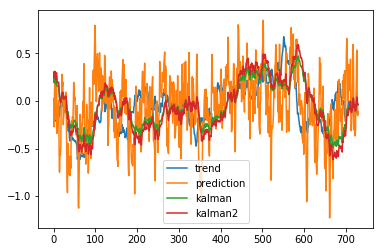

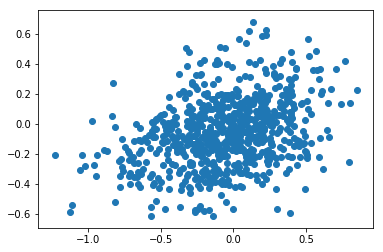

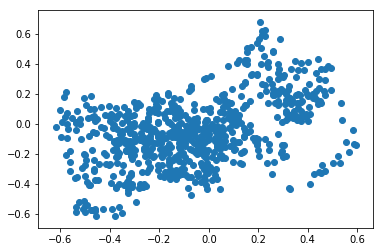

-3.646477850014345


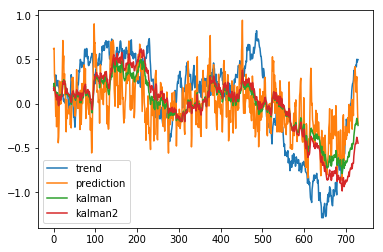

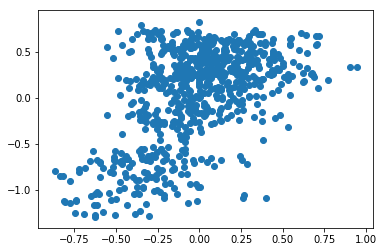

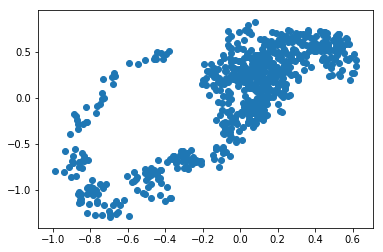

-3.646381727047266


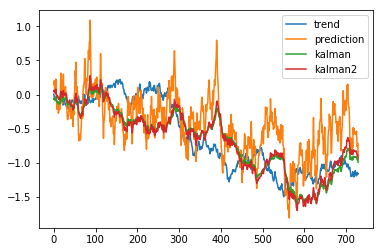

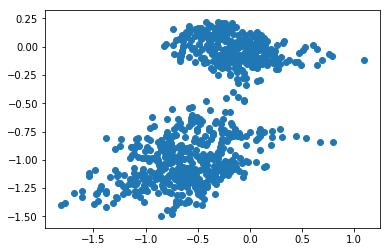

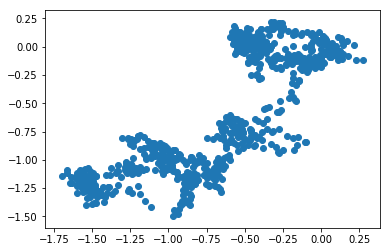

-3.6464082140941185


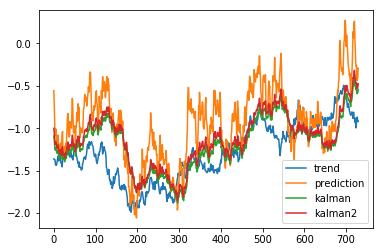

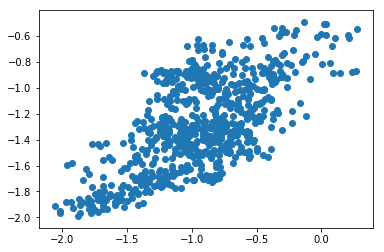

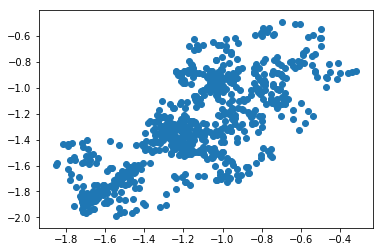

-3.646524687856437


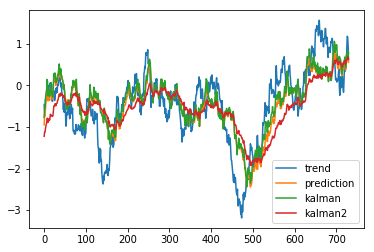

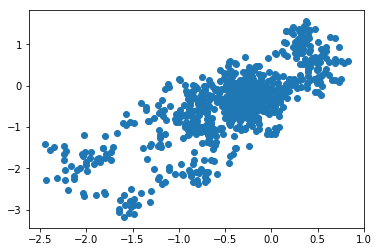

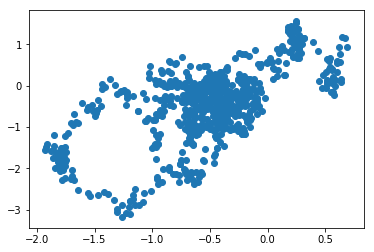

-3.646611832873897


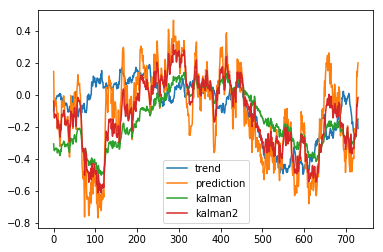

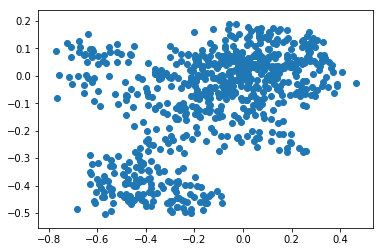

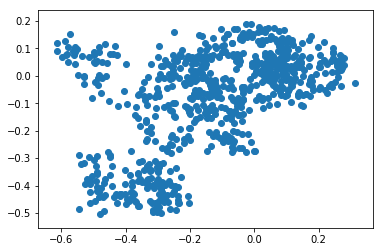

-3.6465147410985095


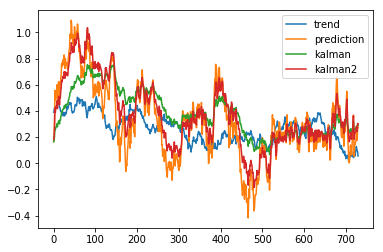

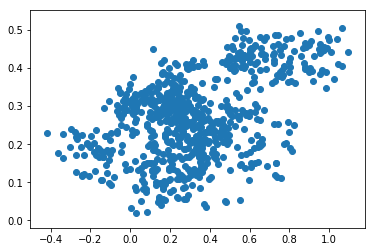

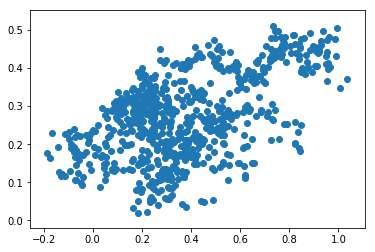

-3.6465923540294183


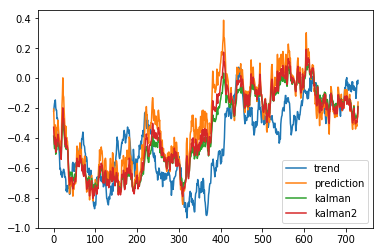

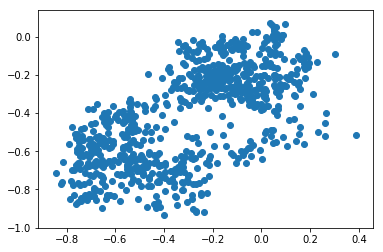

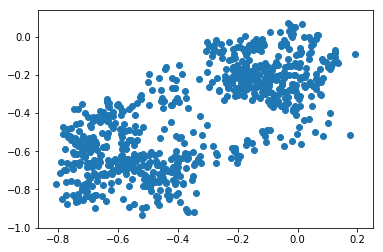

-3.646577887563036


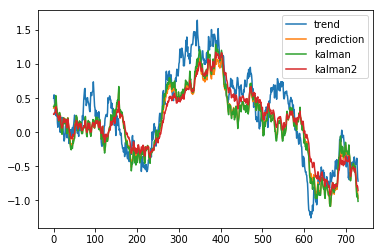

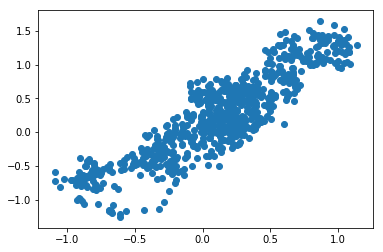

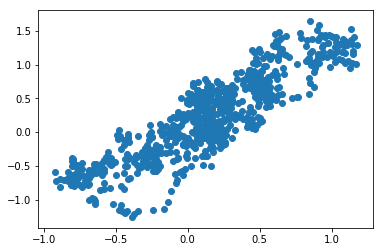

-3.646086589060725


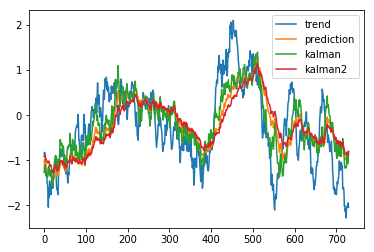

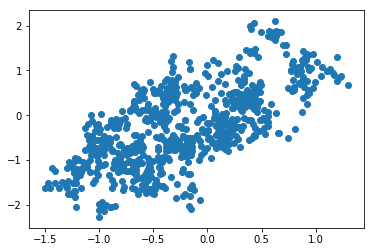

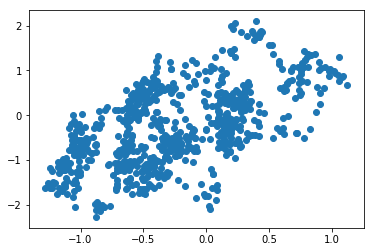

-3.646565373381601


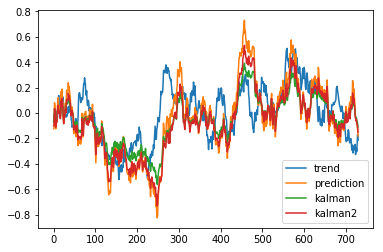

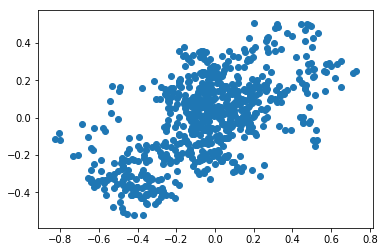

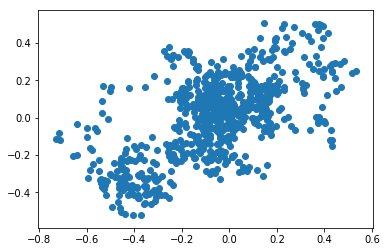

-3.6462192203383905


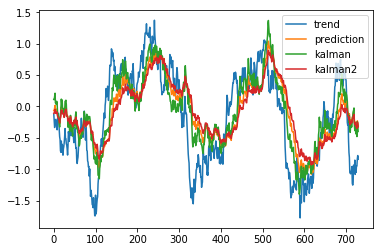

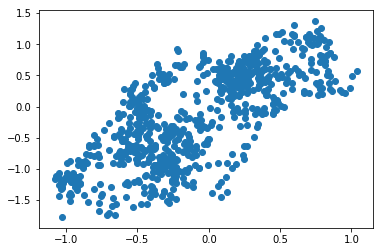

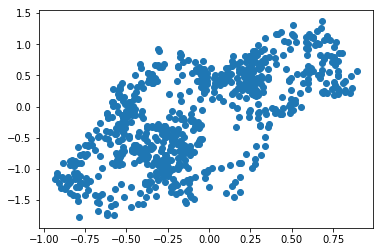

-3.6466877803672118


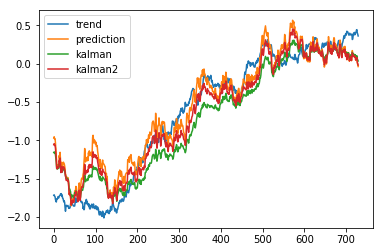

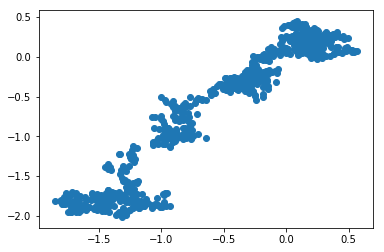

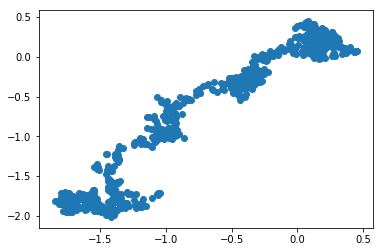

-3.6465911293402327


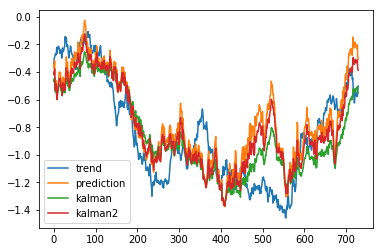

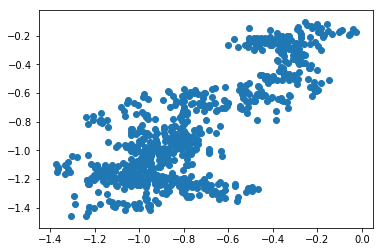

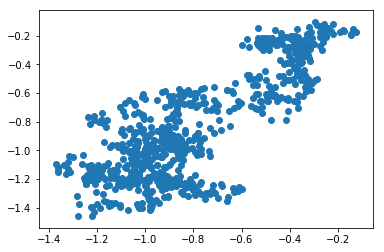

-3.646635406278075


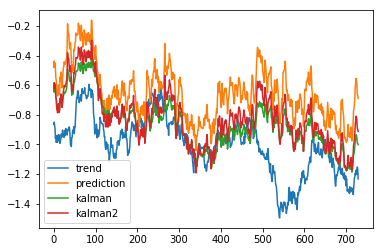

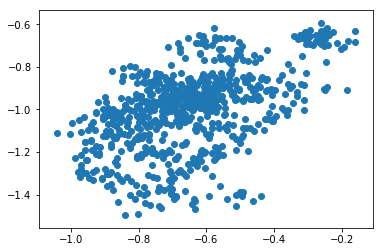

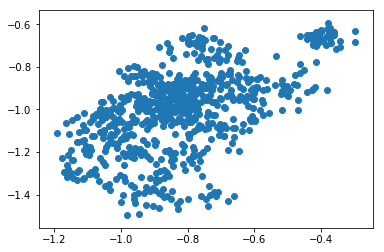

-3.646631708694623


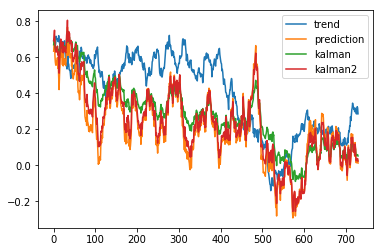

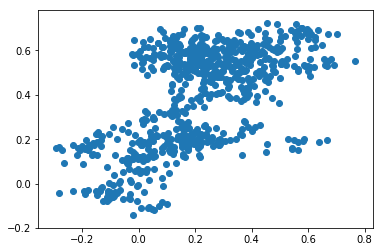

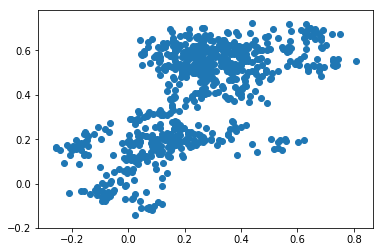

-3.646511555509643


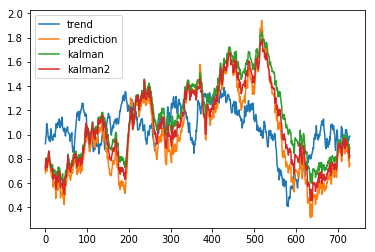

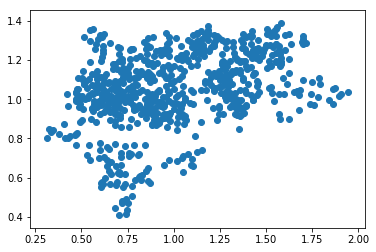

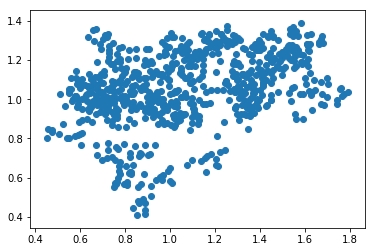

-3.6463208665139986


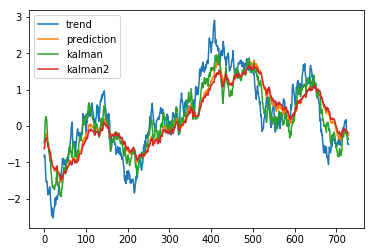

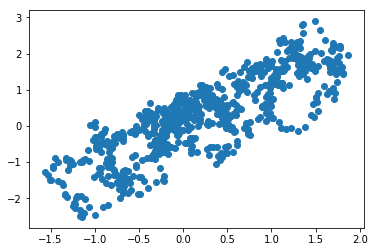

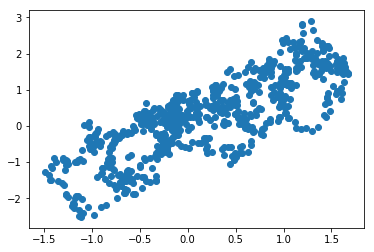

-3.6465241258032632


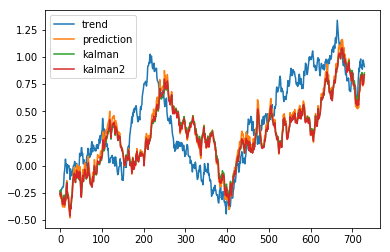

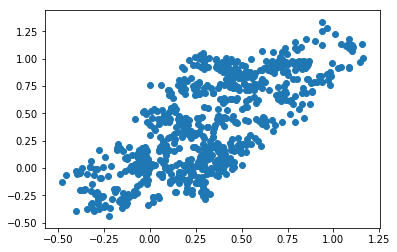

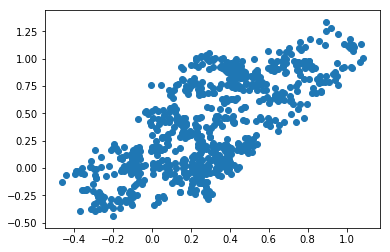

-3.646485393494369


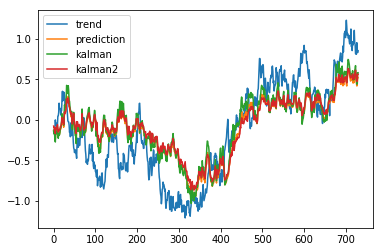

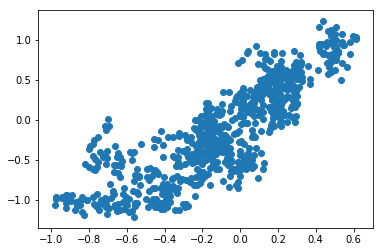

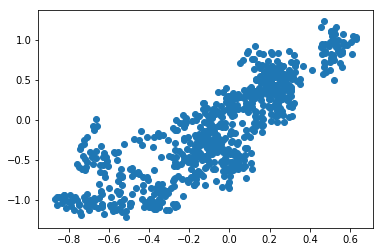

-3.64665406625718


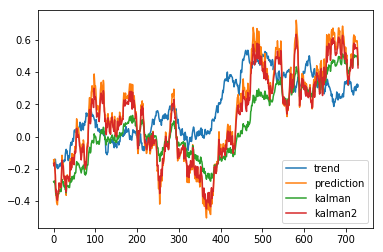

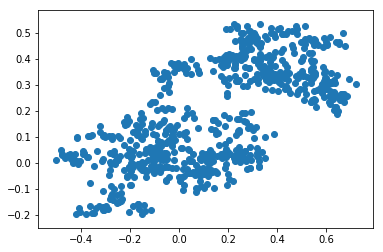

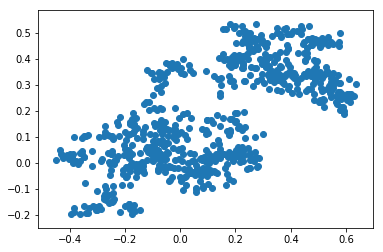

-3.6466016085818422


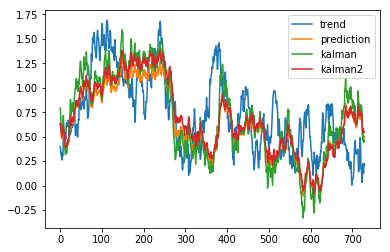

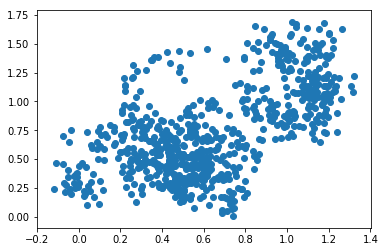

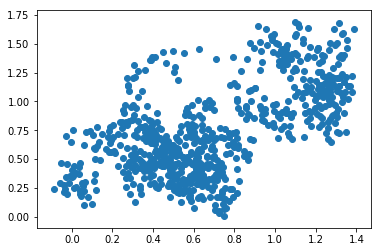

-3.6466927121859056


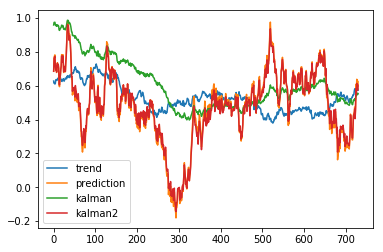

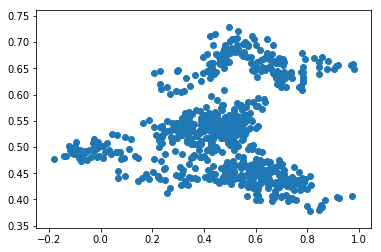

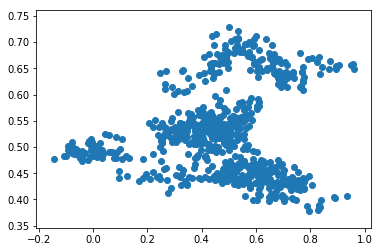

-3.646704011689873


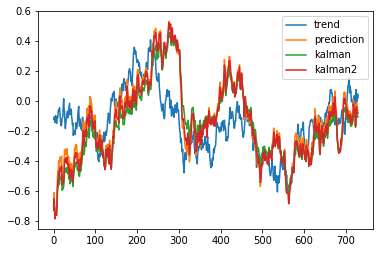

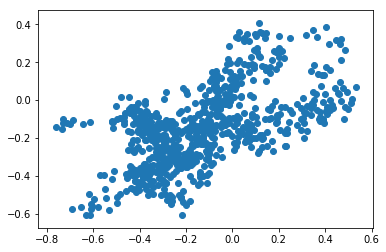

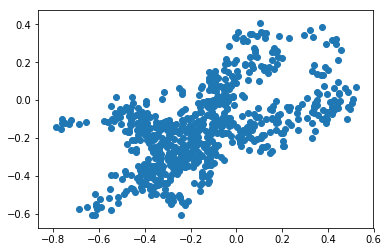

-3.646675617527218


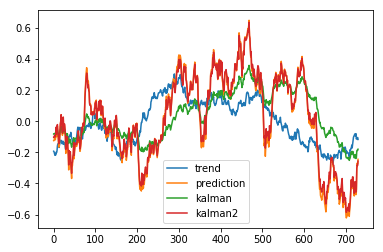

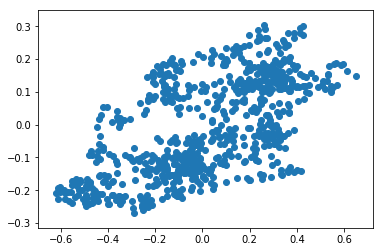

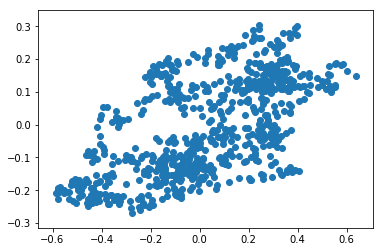

-3.646514591155575


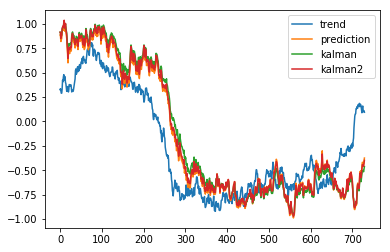

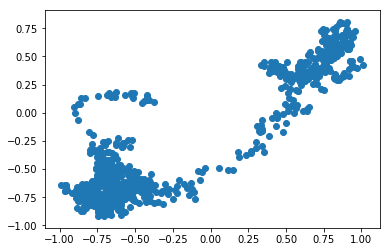

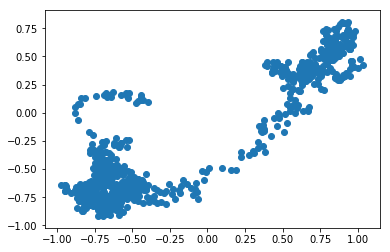

-3.646600531274454


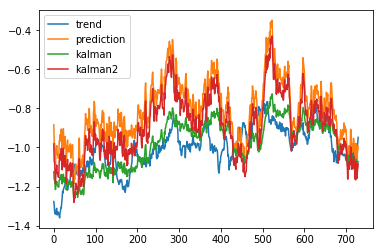

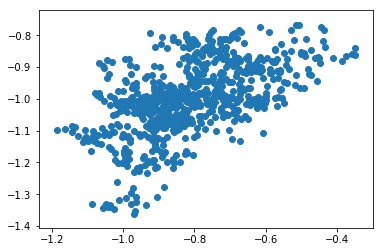

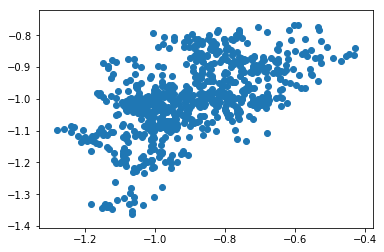

-3.6466073876712484


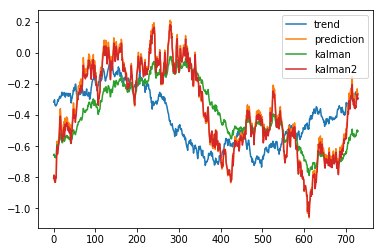

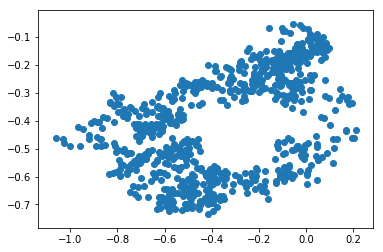

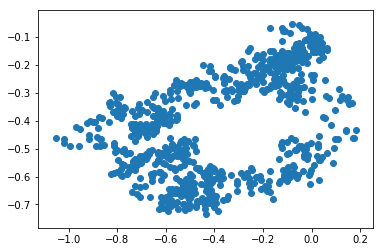

-3.6466344377025974


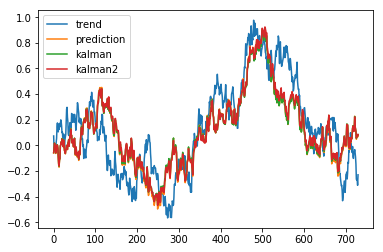

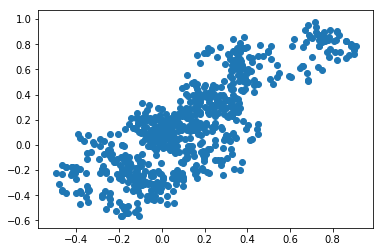

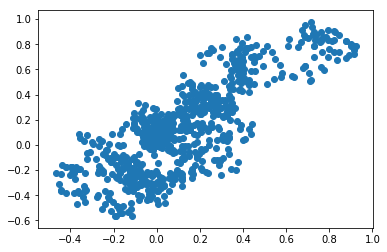

-3.6466247936245066


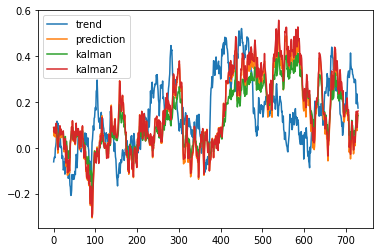

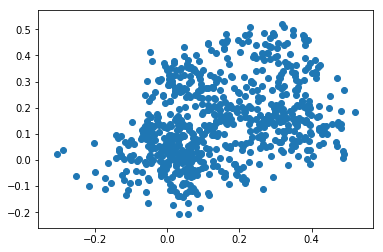

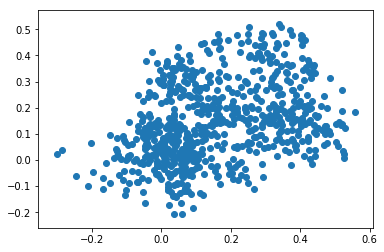

-3.646562648797409


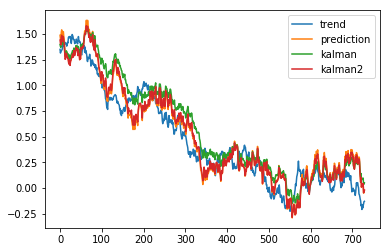

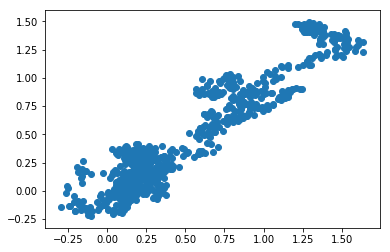

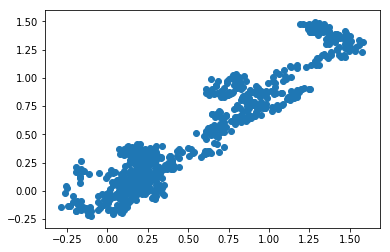

-3.646681054821239


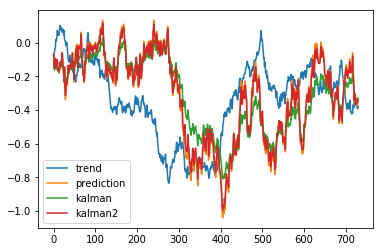

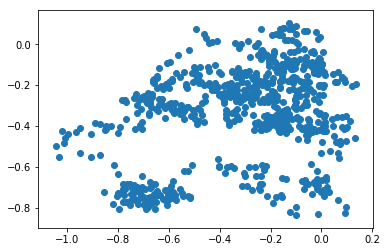

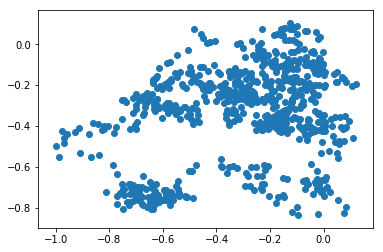

-3.646126524638386


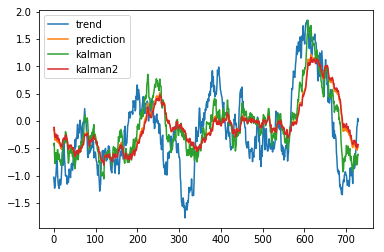

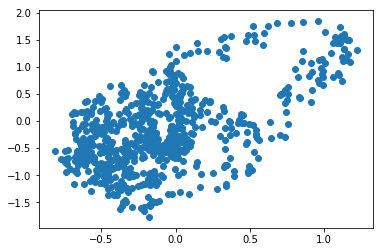

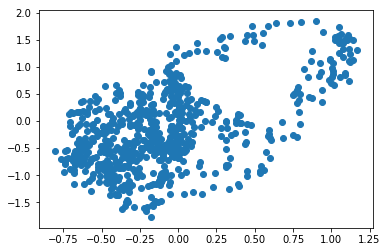

-3.646449555270375


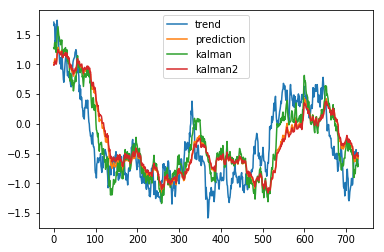

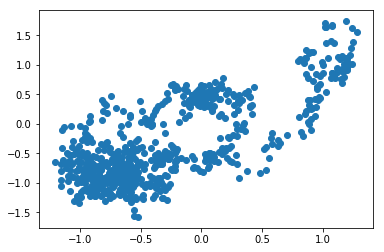

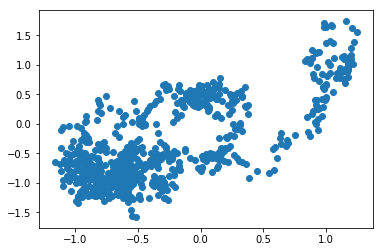

-3.646570801828058


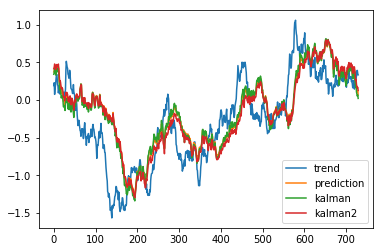

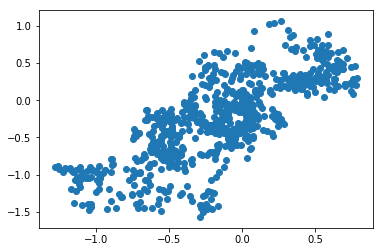

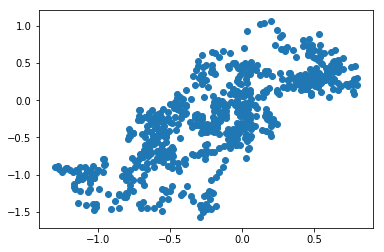

-3.6466165041551006


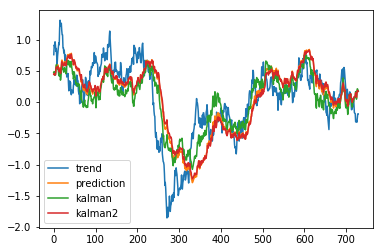

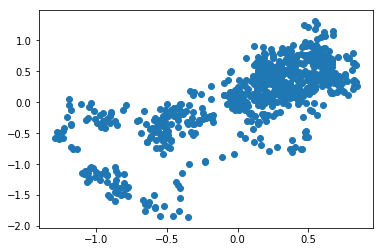

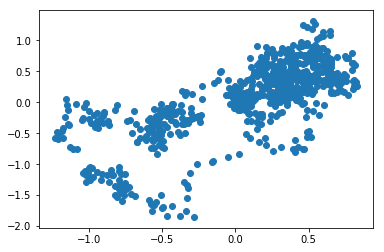

-3.646639763703571


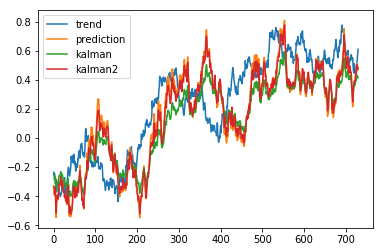

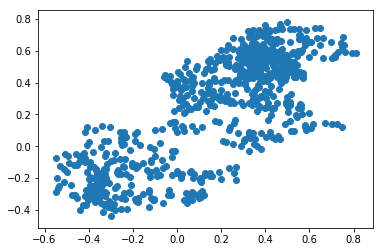

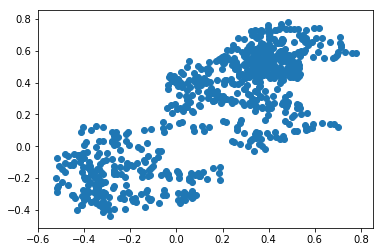

-3.6465801113285137


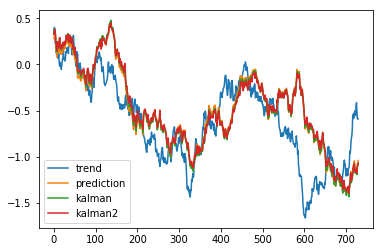

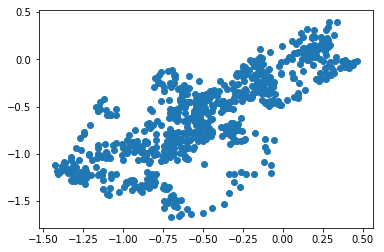

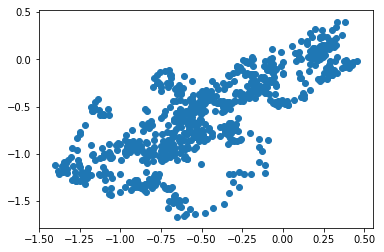

-3.6465972634963704


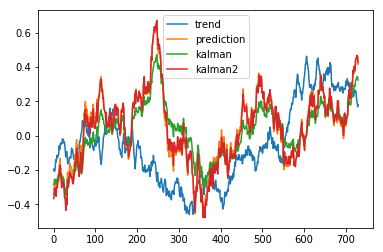

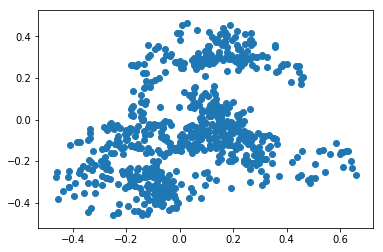

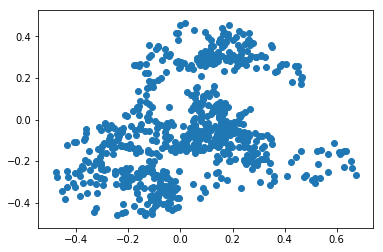

-3.6464991363231105


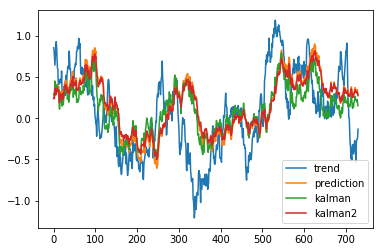

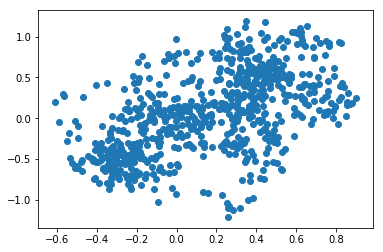

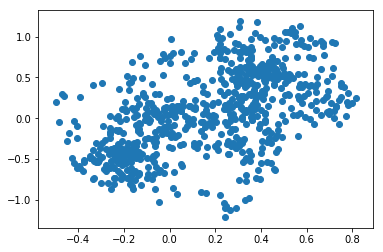

-3.6466221901122493


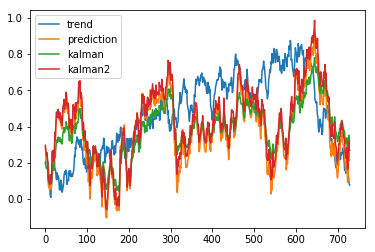

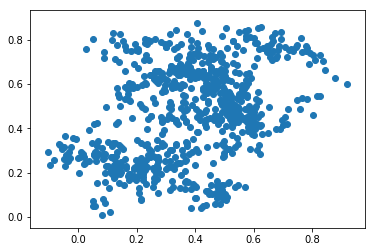

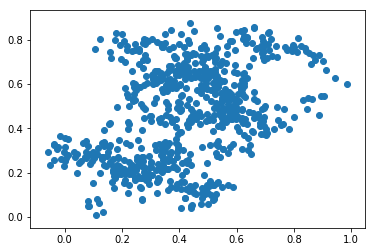

-3.6465323673095567


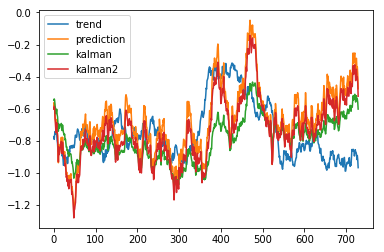

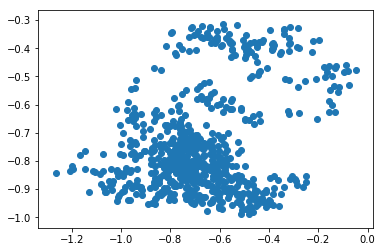

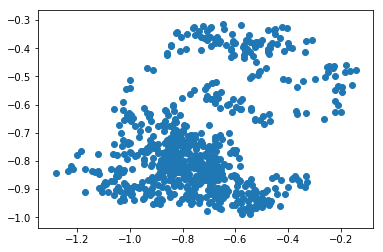

-3.6464787971694035


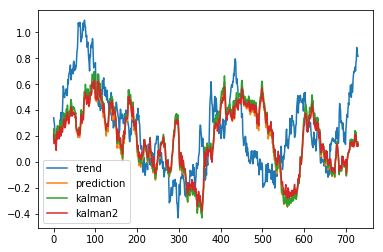

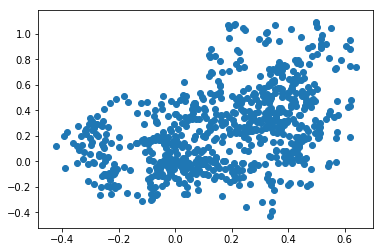

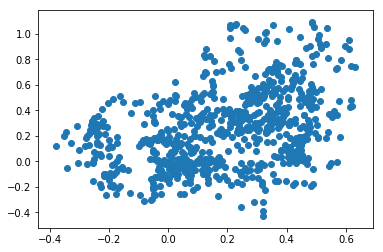

In [ ]:
writer = tf.summary.FileWriter(logs_dir, graph)
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(5000):
        X,Y ,trends, dicti= next(generator)
        state = sess.run( initial_state)
        variables =tf.trainable_variables()
        feed = { inputs_: X,
                initial_state :state,
               targets_: Y ,
               learning_rate: 0.001,
               grad_clip: 0.1}
        if (i+1) %100 == 0 :
            result = sess.run( [cost, outputs], feed_dict=feed)
            print( result[0]-noise**2)
            plt.plot( trends[1:,0][start:], label='trend')
            plt.plot( result[1][0,:,0][start:] , label='prediction')
            kalman_result =  kalman.kalman_estimate( X[0, :,0] ,
                                 sigmaS =noise/np.sqrt(365.) ,
                                 lbd=dicti['lbd'],
                                 sigmamu= dicti['sigma'],
                                 deltaT=dicti['deltaT'] )
            plt.plot(kalman_result[start:], label='kalman' )
            """
            fake result 
            
            """
            index=0
            lbd = 1
            sigma = 0.9
            sigmaS= 0.1
            deltaT= 1./365
            kalman_result =  kalman.kalman_estimate( X[index, :,0] ,
                                             sigmaS =sigmaS ,
                                             lbd=lbd,
                                             sigmamu= sigma,
                                             deltaT=deltaT )
            plt.plot(kalman_result[start:], label='kalman2' )
            plt.legend( loc='best')
            plt.show()
                        
            plt.scatter( result[1][0,start:,0], trends[1:,0][start:])
            plt.show()
            plt.scatter( kalman_result[start:], trends[1:,0][start:])
            plt.show()
        sess.run( [optimizer], feed_dict=feed)
        

writer.close()   

In [ ]:
len(kalman_result[start:])

In [ ]:
dicti

In [ ]:
index=0
lbd = 1
sigma = 0.9
sigmaS= 0.1
deltaT= 1./365
kalman_result =  kalman.kalman_estimate( X[index, :,0] ,
                                 sigmaS =sigmaS ,
                                 lbd=lbd,
                                 sigmamu= sigma,
                                 deltaT=deltaT )
plt.plot(kalman_result, label='kalman' )
#plt.plot(X[index,:,0])
plt.plot( result[1][index,:,0] , label = 'prediction')
plt.plot( trends[1:,0] , label= 'truth')
plt.legend( loc='best')
plt.show()

In [ ]:
plt.scatter( result[1][0,:,0], trends[1:,0])
plt.show()

In [ ]:
plt.plot(Y[0,:,0])
plt.show()